In [1]:
!pip install xmltodict
!pip install split-folders
!pip install GPUtil
import os

import numpy as np
import cv2
import uuid
import time
import pandas as pd

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a v

In [2]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [4]:
img_names=[] 
annotations=[]
for dirname, _, filenames in os.walk("car"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)
    
img_names[:10]

['Cars207.png',
 'Cars213.png',
 'Cars53.png',
 'Cars47.png',
 'Cars90.png',
 'Cars159.png',
 'Cars84.png',
 'Cars171.png',
 'Cars165.png',
 'Cars398.png']

In [5]:
annotations[:10]

['Cars213.xml',
 'Cars207.xml',
 'Cars398.xml',
 'Cars367.xml',
 'Cars401.xml',
 'Cars415.xml',
 'Cars373.xml',
 'Cars429.xml',
 'Cars47.xml',
 'Cars53.xml']

In [8]:
path_annotations="car/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
        
classes = ['license']

In [9]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars213.png,400,300,150,160,233,194
1,Cars207.png,400,478,254,229,372,264
2,Cars398.png,400,300,72,139,196,222
3,Cars367.png,450,299,224,161,382,222
4,Cars401.png,400,300,158,223,238,240
...,...,...,...,...,...,...,...
466,Cars418.png,400,225,99,70,303,155
467,Cars395.png,400,301,241,182,288,205
468,Cars381.png,400,225,65,131,147,155
469,Cars222.png,400,230,178,158,235,170


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


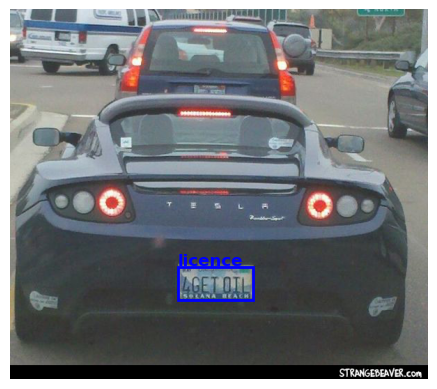

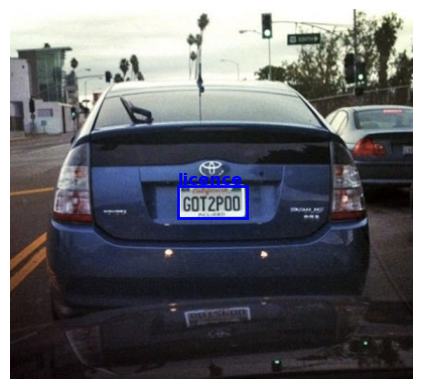

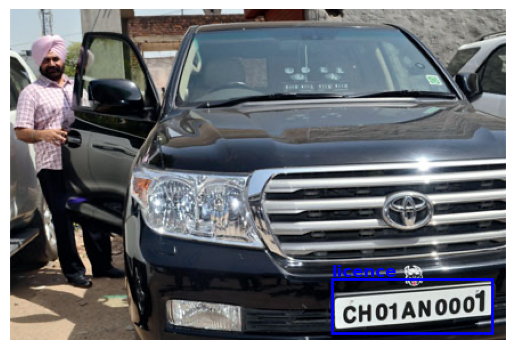

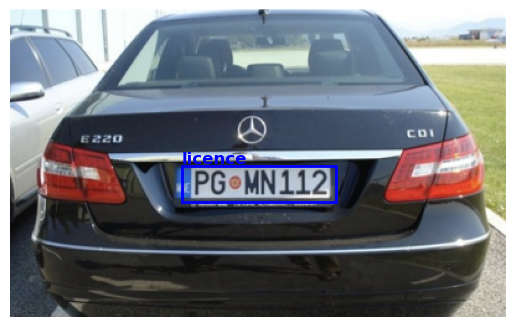

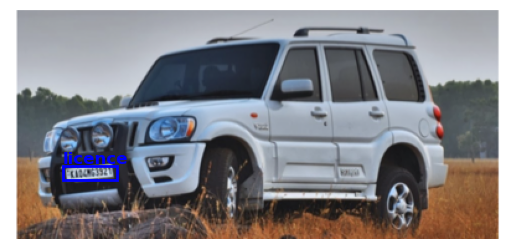

In [12]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')
                    
photos_path = "car/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [15]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("outputs/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("outputs/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars213.png,400,300,150,160,233,194,0.001473,0.001813,-0.001164,-0.002457
1,Cars207.png,400,478,254,229,372,264,0.001448,0.001115,-0.001310,-0.001676
2,Cars398.png,400,300,72,139,196,222,0.001645,0.001978,-0.000128,-0.001464
3,Cars367.png,450,299,224,161,382,222,0.001341,0.001902,-0.000844,-0.001966
4,Cars401.png,400,300,158,223,238,240,0.001460,0.001726,-0.001239,-0.002979
...,...,...,...,...,...,...,...,...,...,...,...
466,Cars418.png,400,225,99,70,303,155,0.001671,0.002832,0.000025,-0.000789
467,Cars395.png,400,301,241,182,288,205,0.001352,0.001754,-0.001888,-0.002763
468,Cars381.png,400,225,65,131,147,155,0.001599,0.002394,-0.000408,-0.003412
469,Cars222.png,400,230,178,158,235,170,0.001402,0.002251,-0.001590,-0.003887


In [16]:
input_folder = Path("outputs")
output_folder = Path("outputs")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 434 files [00:00, 748.53 files/s]

Moving files finished.


In [17]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 4 directiories and 433 files in 'outputs' folder 
There are 0 directiories and 433 files in 'outputs/labels' folder 
There are 2 directiories and 0 files in 'outputs/train' folder 
There are 0 directiories and 346 files in 'outputs/train/labels' folder 
There are 0 directiories and 0 files in 'outputs/train/.ipynb_checkpoints' folder 
There are 0 directiories and 1 files in 'outputs/.ipynb_checkpoints' folder 
There are 2 directiories and 0 files in 'outputs/val' folder 
There are 0 directiories and 87 files in 'outputs/val/labels' folder 
There are 0 directiories and 1 files in 'outputs/val/.ipynb_checkpoints' folder 

There are 4 directiories and 433 files in 'outputs' folder 
There are 0 directiories and 433 files in 'outputs/labels' folder 
There are 2 directiories and 0 files in 'outputs/train' folder 
There are 0 directiories and 346 files in 'outputs/train/labels' folder 
There are 0 directiories and 0 files in 'outputs/train/.ipynb_checkpoints' folder 
There are 0 dir

In [18]:
import yaml

yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/Plate_recognition",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [19]:
def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [20]:
device = '0' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

In [21]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --device {device} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-272-gde64179 Python-3.11.4 torch-2.1.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0